In [ ]:
# AQI Forecasting System (Mumbai)
# Using XGBoost

In [340]:
#import pandas and the first(main) dataset
import pandas as pd
data = pd.read_csv("../data/raw/malad.csv")
data.head()

,date,pm25,pm10,o3,no2,so2,co
0,2026/1/1,80,78,63,20,5,4
1,2026/1/2,116,86,54,25,6,5
2,2026/1/3,117,103,48,26,5,7
3,2026/1/4,156,102,76,26,7,7
4,2026/1/5,152,113,76,34,7,8


In [341]:
#getting to know the dataset and handling type conversion
data.info()
data.columns = data.columns.str.strip()
num_cols = ["pm25","pm10","o3","no2","so2","co"]
data[num_cols] = data[num_cols].apply(pd.to_numeric, errors="coerce")
data["date"] = pd.to_datetime(data["date"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326 entries, 0 to 1325
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1326 non-null   object
 1    pm25   1326 non-null   object
 2    pm10   1326 non-null   object
 3    o3     1326 non-null   object
 4    no2    1326 non-null   object
 5    so2    1326 non-null   object
 6    co     1326 non-null   object
dtypes: object(7)
memory usage: 72.6+ KB


In [342]:
#handling null values by dropping important ones & interpolating others
data = data.dropna(subset=["pm25"])
num_cols = ["pm10","o3","no2","so2","co"]
data = data.sort_values("date")
data = data.set_index("date")
data[num_cols] = data[num_cols].interpolate(method="time")
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1074 entries, 2021-12-28 to 2026-01-06
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pm25    1074 non-null   float64
 1   pm10    1074 non-null   float64
 2   o3      1074 non-null   float64
 3   no2     1074 non-null   float64
 4   so2     1074 non-null   float64
 5   co      1074 non-null   float64
dtypes: float64(6)
memory usage: 58.7 KB


In [343]:
data["month"] = data.index.month_name()

In [344]:
data = data.sort_values("date", ascending=False)
data.head()

,pm25,pm10,o3,no2,so2,co,month
date,,,,,,,
2026-01-06,154.0,113.0,76.0,34.0,7.0,8.0,January
2026-01-05,152.0,113.0,76.0,34.0,7.0,8.0,January
2026-01-04,156.0,102.0,76.0,26.0,7.0,7.0,January
2026-01-03,117.0,103.0,48.0,26.0,5.0,7.0,January
2026-01-02,116.0,86.0,54.0,25.0,6.0,5.0,January


In [345]:
#calculating all-over aqi using linear interpolating => breakpoint comparison according to CPCB and assigning based on max sub-index
#c_high/low = low and high breakpoints of the concentration (value) and i_high/low = the index the conc corresponds to
#the breakpoints of the pollutants to be defined individually.
def calc_subindex(val,breakpoints):
    for bp in breakpoints:
        if bp["c_low"] <= val <= bp["c_high"]:
            return ((bp["i_high"]-bp["i_low"])/(bp["c_high"]-bp["c_low"]))*(val-bp["c_low"])+bp["i_low"]

In [346]:
#all breakpoints
pm25_breakpoints = [
    {"c_low": 0,   "c_high": 30,  "i_low": 0,   "i_high": 50},
    {"c_low": 30,  "c_high": 60,  "i_low": 50,  "i_high": 100},
    {"c_low": 60,  "c_high": 90,  "i_low": 100, "i_high": 200},
    {"c_low": 90,  "c_high": 120, "i_low": 200, "i_high": 300},
    {"c_low": 120, "c_high": 250, "i_low": 300, "i_high": 400},
    {"c_low": 250, "c_high": 500, "i_low": 400, "i_high": 500},
]
pm10_breakpoints = [
    {"c_low": 0, "c_high": 50, "i_low": 0, "i_high": 50},
    {"c_low": 51, "c_high": 100, "i_low": 51, "i_high": 100},
    {"c_low": 101, "c_high": 250, "i_low": 101, "i_high": 200},
    {"c_low": 251, "c_high": 350, "i_low": 201, "i_high": 300},
    {"c_low": 351, "c_high": 430, "i_low": 301, "i_high": 400},
    {"c_low": 431, "c_high": 600, "i_low": 401, "i_high": 500}
]
no2_breakpoints = [
    {"c_low": 0, "c_high": 40, "i_low": 0, "i_high": 50},
    {"c_low": 41, "c_high": 80, "i_low": 51, "i_high": 100},
    {"c_low": 81, "c_high": 180, "i_low": 101, "i_high": 200},
    {"c_low": 181, "c_high": 280, "i_low": 201, "i_high": 300},
    {"c_low": 281, "c_high": 400, "i_low": 301, "i_high": 400},
    {"c_low": 401, "c_high": 1000, "i_low": 401, "i_high": 500},
]
so2_breakpoints = [
    {"c_low": 0, "c_high": 40, "i_low": 0, "i_high": 50},
    {"c_low": 41, "c_high": 80, "i_low": 51, "i_high": 100},
    {"c_low": 81, "c_high": 380, "i_low": 101, "i_high": 200},
    {"c_low": 381, "c_high": 800, "i_low": 201, "i_high": 300},
    {"c_low": 801, "c_high": 1600, "i_low": 301, "i_high": 400},
    {"c_low": 1601, "c_high": 2000, "i_low": 401, "i_high": 500},
]
o3_breakpoints = [
    {"c_low": 0, "c_high": 50, "i_low": 0, "i_high": 50},
    {"c_low": 51, "c_high": 100, "i_low": 51, "i_high": 100},
    {"c_low": 101, "c_high": 168, "i_low": 101, "i_high": 200},
    {"c_low": 169, "c_high": 208, "i_low": 201, "i_high": 300},
    {"c_low": 209, "c_high": 748, "i_low": 301, "i_high": 400},
    {"c_low": 749, "c_high": 1000, "i_low": 401, "i_high": 500},
]
co_breakpoints = [
    {"c_low": 0.0, "c_high": 1.0, "i_low": 0, "i_high": 50},
    {"c_low": 1.1, "c_high": 2.0, "i_low": 51, "i_high": 100},
    {"c_low": 2.1, "c_high": 10.0, "i_low": 101, "i_high": 200},
    {"c_low": 10.1, "c_high": 17.0, "i_low": 201, "i_high": 300},
    {"c_low": 17.1, "c_high": 34.0, "i_low": 301, "i_high": 400},
    {"c_low": 34.1, "c_high": 50.0, "i_low": 401, "i_high": 500},
]

In [347]:
#calculating pollutant specific aqi
data["aqi_pm25"] = data["pm25"].apply(
    lambda x: calc_subindex(x, pm25_breakpoints)
)
data["aqi_pm10"] = data["pm10"].apply(
    lambda x: calc_subindex(x, pm10_breakpoints)
)
data["aqi_o3"] = data["o3"].apply(
    lambda x: calc_subindex(x, o3_breakpoints)
)
data["aqi_no2"] = data["no2"].apply(
    lambda x: calc_subindex(x, no2_breakpoints)
)
data["aqi_so2"] = data["so2"].apply(
    lambda x: calc_subindex(x, so2_breakpoints)
)
data["aqi_co"] = data["co"].apply(
    lambda x: calc_subindex(x, co_breakpoints)
)
data.head()

,pm25,pm10,o3,no2,so2,co,month,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co
date,,,,,,,,,,,,,
2026-01-06,154.0,113.0,76.0,34.0,7.0,8.0,January,326.153846,108.973154,76.0,42.50,8.75,174.936709
2026-01-05,152.0,113.0,76.0,34.0,7.0,8.0,January,324.615385,108.973154,76.0,42.50,8.75,174.936709
2026-01-04,156.0,102.0,76.0,26.0,7.0,7.0,January,327.692308,101.664430,76.0,32.50,8.75,162.405063
2026-01-03,117.0,103.0,48.0,26.0,5.0,7.0,January,290.000000,102.328859,48.0,32.50,6.25,162.405063
2026-01-02,116.0,86.0,54.0,25.0,6.0,5.0,January,286.666667,86.000000,54.0,31.25,7.50,137.341772


In [348]:
#calculating the final aqi
aqi_cols = ["aqi_pm25","aqi_pm10","aqi_o3","aqi_no2","aqi_so2","aqi_co"]
data["final_aqi"] = data[aqi_cols].max(axis=1)
data.head()

,pm25,pm10,o3,no2,so2,co,month,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co,final_aqi
date,,,,,,,,,,,,,,
2026-01-06,154.0,113.0,76.0,34.0,7.0,8.0,January,326.153846,108.973154,76.0,42.50,8.75,174.936709,326.153846
2026-01-05,152.0,113.0,76.0,34.0,7.0,8.0,January,324.615385,108.973154,76.0,42.50,8.75,174.936709,324.615385
2026-01-04,156.0,102.0,76.0,26.0,7.0,7.0,January,327.692308,101.664430,76.0,32.50,8.75,162.405063,327.692308
2026-01-03,117.0,103.0,48.0,26.0,5.0,7.0,January,290.000000,102.328859,48.0,32.50,6.25,162.405063,290.000000
2026-01-02,116.0,86.0,54.0,25.0,6.0,5.0,January,286.666667,86.000000,54.0,31.25,7.50,137.341772,286.666667


In [2]:
#using seaborn & matplotlib for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

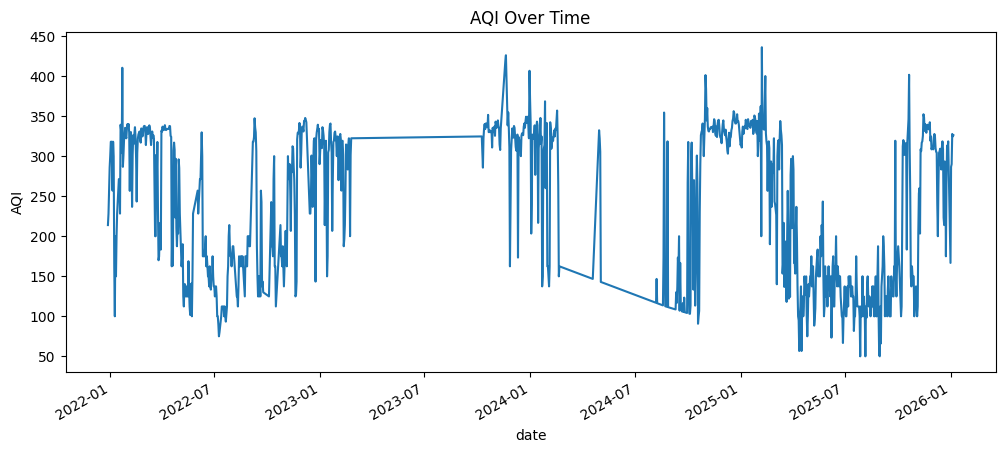

In [350]:
plt.figure()
data["final_aqi"].plot(figsize=(12,5))
plt.title("AQI Over Time")
plt.ylabel("AQI")
plt.show()

In [ ]:
#we can see a steady horizontal line in the database: indicating no values for that period of time. 
#this can be dangerous for the model to train upon. thus, using two more datasets of 2023 aqi, and one more for 2024 for the constant slope
#which indicates strongly interpolated values => again harmful for model.

In [508]:
#new databases
data2 = pd.read_csv("../data/raw/malad_leftout.csv") #2023
data3 = pd.read_csv("../data/raw/malad_lost2.csv") #2023
data4 = pd.read_csv("../data/raw/malad_2024_lost.csv") #2024

In [ ]:
#converting datatypes and assigning index
data2["date"] = pd.to_datetime(data2["From Date"], errors="coerce")
data2 = data2.set_index("date")

data3["date"] = pd.to_datetime(data3["date"], errors="coerce")
data3 = data3.set_index("date")
data3 = data3.dropna()

data4.index = pd.to_datetime(data4.index, errors="coerce", format="%d-%m-%Y")
data4 = data4.set_index("date")

#dropping unuseful columns and renaming existing ones to match original dataset
#data2:
data2 = data2.drop(columns=["From Date","To Date","NO","NOx","NH3","Toluene","Eth-Benzene","MP-Xylene","RH","WS","WD","BP","AT","RF","TOT-RF","Benzene","Unnamed: 0"])
new_names = {"PM2.5":"pm25","PM10":"pm10","NO2":"no2","SO2":"so2","CO":"co","Ozone":"o3"}
data2 = data2.rename(columns = new_names)
#data3:
col_sub = data3.columns[0:23]
data3 = data3.drop(columns = col_sub)
#removing the interpolated values from original dataset
data = data.drop(data.loc["2024-06-11":"2024-08-30"].index)

In [510]:
#because there are many null values -> especially in the most important pm25 values + dropping all empty vals from dataset3
data2 = data2.dropna(subset=["pm25","pm10"],how="all")

In [511]:
data2 = data2.sort_index()
data3 = data3.sort_index()
data4 = data4.sort_index()

In [520]:
#since databsase2 has hourly data: we need to convert it to daily data by calculating mean of each day.
def hourly_to_daily(hourly_df, min_hours=18): 
    # Ensure datetime index
    hourly_df = hourly_df.copy()
    hourly_df.index = pd.to_datetime(hourly_df.index)
    hourly_df = hourly_df.sort_index()

    # Count how many valid readings per day
    counts = hourly_df.resample("D").count()

    # Daily mean (NaNs ignored automatically)
    daily = hourly_df.resample("D").mean()

    # Keep only days with enough PM data
    valid = (counts["pm25"] >= min_hours) | (counts["pm10"] >= min_hours)
    daily = daily[valid]

    return daily

In [521]:
daily2 = hourly_to_daily(data2)

In [522]:
#calculating individual aqi for second database
daily2["aqi_pm25"] = daily2["pm25"].apply(
    lambda x: calc_subindex(x, pm25_breakpoints)
)
daily2["aqi_pm10"] = daily2["pm10"].apply(
    lambda x: calc_subindex(x, pm10_breakpoints)
)
daily2["aqi_o3"] = daily2["o3"].apply(
    lambda x: calc_subindex(x, o3_breakpoints)
)
daily2["aqi_no2"] = daily2["no2"].apply(
    lambda x: calc_subindex(x, no2_breakpoints)
)
daily2["aqi_so2"] = daily2["so2"].apply(
    lambda x: calc_subindex(x, so2_breakpoints)
)
daily2["aqi_co"] = daily2["co"].apply(
    lambda x: calc_subindex(x, co_breakpoints)
)
daily2.head()

,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co
date,,,,,,,,,,,,
2021-01-01,218.613617,273.206809,30.764362,6.965106,1.412553,51.508511,375.856628,223.206809,51.508511,38.455452,8.706383,68.016785
2021-01-02,167.722088,157.703111,70.042941,3.223222,1.142727,37.940000,336.709298,138.675221,37.940000,87.489849,4.029028,53.326263
2021-01-03,89.087684,157.160213,4.667474,3.103191,0.051474,73.786526,196.958947,138.314504,73.786526,5.834342,3.878989,2.573684
2021-01-04,36.376000,160.503789,6.500947,6.688316,0.565684,15.409684,60.626667,140.536075,15.409684,8.126184,8.360395,28.284211
2021-01-05,26.300638,71.653000,6.316915,6.235579,0.882316,23.328842,43.834397,71.653000,23.328842,7.896144,7.794474,44.115789


In [523]:
#calculating final_aqi
aqi_cols = ["aqi_pm25","aqi_pm10","aqi_o3","aqi_no2","aqi_so2","aqi_co"]
daily2["final_aqi"] = daily2[aqi_cols].max(axis=1)
daily2.head(2)

,pm25,pm10,no2,so2,co,o3,aqi_pm25,aqi_pm10,aqi_o3,aqi_no2,aqi_so2,aqi_co,final_aqi
date,,,,,,,,,,,,,
2021-01-01,218.613617,273.206809,30.764362,6.965106,1.412553,51.508511,375.856628,223.206809,51.508511,38.455452,8.706383,68.016785,375.856628
2021-01-02,167.722088,157.703111,70.042941,3.223222,1.142727,37.940000,336.709298,138.675221,37.940000,87.489849,4.029028,53.326263,336.709298


In [524]:
cols_to_drop2 = [c for c in daily2.columns if c != "final_aqi"]
daily2 = daily2.drop(columns = cols_to_drop2)

In [535]:
#merging database1 and database2 => merged dataset
data = data.sort_index()
daily2 = daily2.sort_index()
final = data.combine_first(daily2)

In [543]:
final = final.drop(final.loc[:"2021-12-31"].index)

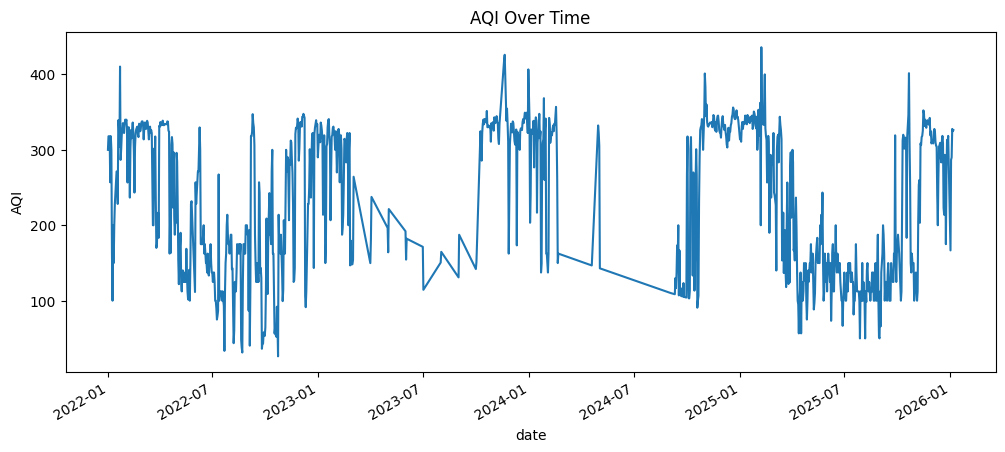

In [544]:
plt.figure()
final["final_aqi"].plot(figsize=(12,5))
plt.title("AQI Over Time")
plt.ylabel("AQI")
plt.show()

In [545]:
final_data2 = final.combine_first(data3)

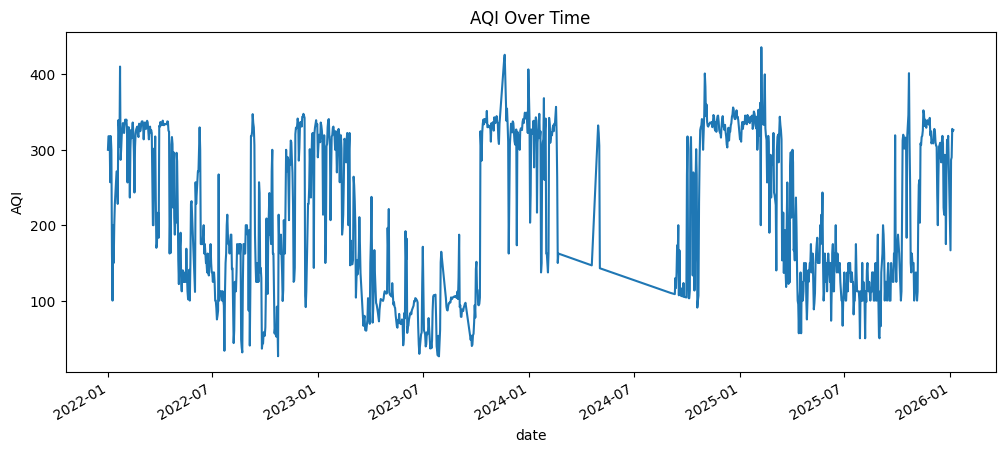

In [546]:
plt.figure()
final_data2["final_aqi"].plot(figsize=(12,5))
plt.title("AQI Over Time")
plt.ylabel("AQI")
plt.show()

In [547]:
final_data2 = final_data2.dropna() #removing that one NAT value from data 3

In [548]:
final_aqi_data = final_data2.combine_first(data4)

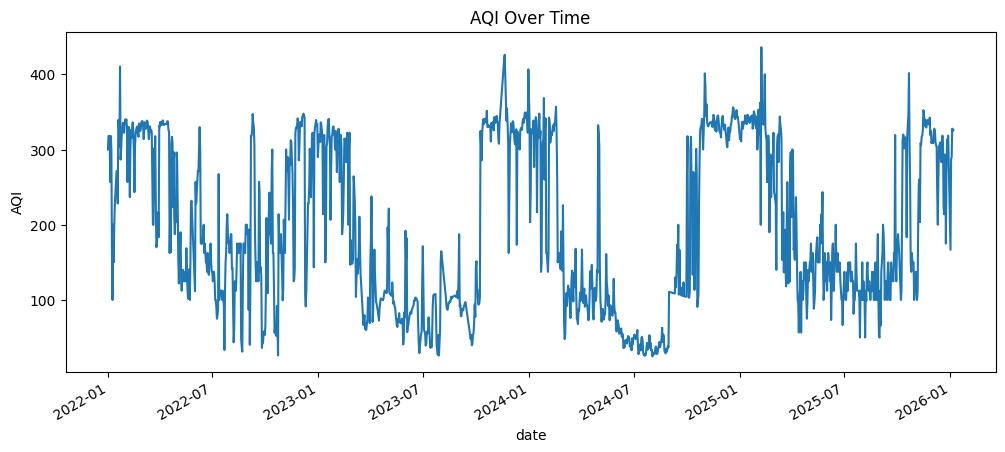

In [549]:
#plotting the final dataset
plt.figure()
final_aqi_data["final_aqi"].plot(figsize=(12,5))
plt.title("AQI Over Time")
plt.ylabel("AQI")
plt.show()

In [551]:
#saving the final dataframe
final_aqi_data.to_csv("../data/processed/final_aqi_dataset.csv") 

<Axes: >

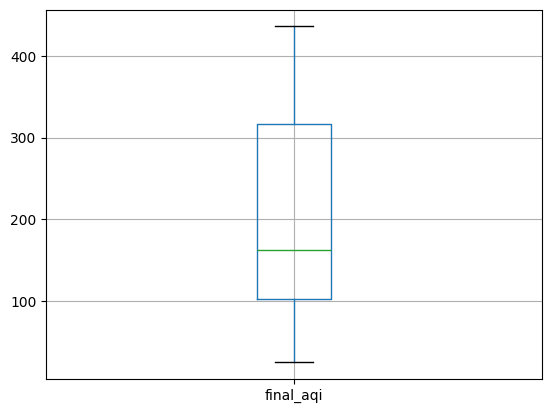

In [17]:
#next step -> setting the features; rolling mean, lag, etc. and save in global.
#first -> checking for outliers in data
import pandas as pd
final_aqi_data = pd.read_csv("../data/processed/final_aqi_dataset.csv")
plt.figure()
final_aqi_data.boxplot()

In [ ]:
#no outliers in the new data. thus now we can move forward.
#creating lag data
# step 2 -> feature engineering
for lag in [1, 2, 3, 7, 14]:
    final_aqi_data[f"aqi_lag_{lag}"] = final_aqi_data["final_aqi"].shift(lag)


In [19]:
final_aqi_data.head()

,date,final_aqi,aqi_lag_1,aqi_lag_2,aqi_lag_3,aqi_lag_7,aqi_lag_14
0,2022-01-01,300.000000,NaN,NaN,NaN,NaN,NaN
1,2022-01-02,317.988166,300.000000,NaN,NaN,NaN,NaN
2,2022-01-03,317.988166,317.988166,300.000000,NaN,NaN,NaN
3,2022-01-04,317.988166,317.988166,317.988166,300.000000,NaN,NaN
4,2022-01-05,256.956522,317.988166,317.988166,317.988166,NaN,NaN


In [24]:
#adding month,day
final_aqi_data["month"] = final_aqi_data["date"].dt.month
final_aqi_data["day"]   = final_aqi_data["date"].dt.day
final_aqi_data["dow"]   = final_aqi_data["date"].dt.dayofweek
final_aqi_data.head()

,date,final_aqi,aqi_lag_1,aqi_lag_2,aqi_lag_3,aqi_lag_7,aqi_lag_14,month,day,dow
0,2022-01-01,300.000000,NaN,NaN,NaN,NaN,NaN,1,1,5
1,2022-01-02,317.988166,300.000000,NaN,NaN,NaN,NaN,1,2,6
2,2022-01-03,317.988166,317.988166,300.000000,NaN,NaN,NaN,1,3,0
3,2022-01-04,317.988166,317.988166,317.988166,300.000000,NaN,NaN,1,4,1
4,2022-01-05,256.956522,317.988166,317.988166,317.988166,NaN,NaN,1,5,2


In [ ]:
#rolling and std
final_aqi_data["aqi_roll_3"]  = final_aqi_data["final_aqi"].rolling(3).mean()
final_aqi_data["aqi_roll_7"]  = final_aqi_data["final_aqi"].rolling(7).mean()
final_aqi_data["aqi_roll_14"] = final_aqi_data["final_aqi"].rolling(14).mean()

final_aqi_data["aqi_std_7"]  = final_aqi_data["final_aqi"].rolling(7).std()
final_aqi_data["aqi_std_14"] = final_aqi_data["final_aqi"].rolling(14).std()

In [ ]:
#dropping the null valued rows created due to lag, rolling and std featuring
final_data = final_aqi_data.dropna().reset_index(drop=True)

In [37]:
final_data.head()

,date,final_aqi,aqi_lag_1,aqi_lag_2,aqi_lag_3,aqi_lag_7,aqi_lag_14,month,day,dow,aqi_roll_3,aqi_roll_7,aqi_roll_14,aqi_std_7,aqi_std_14
0,2022-01-15,256.956522,242.608696,228.260870,200.000000,162.405063,300.000000,1,15,5,242.608696,196.814215,240.643839,55.226583,71.028839
1,2022-01-16,271.304348,256.956522,242.608696,228.260870,100.000000,317.988166,1,16,6,256.956522,221.286265,237.309281,41.399420,68.156212
2,2022-01-17,271.304348,271.304348,256.956522,242.608696,200.000000,317.988166,1,17,0,266.521739,231.472600,233.974723,43.980764,64.973019
3,2022-01-18,228.260870,271.304348,271.304348,256.956522,149.873418,317.988166,1,18,1,256.956522,242.670807,227.565630,26.076603,60.306098
4,2022-01-19,339.230769,228.260870,271.304348,271.304348,200.000000,256.956522,1,19,2,279.598662,262.560917,233.442362,38.326771,67.024970


In [ ]:
#step 3 -> NOW MODEL BUILDING!!!!!!

In [38]:
#lets define X and Y. Y will be predicted, X is the data we give it.
x = final_data.drop(columns=["final_aqi","date"])
y = final_data["final_aqi"]

In [ ]:
# splitting the data 80:20 -> 80 train 20 test
split = int(len(final_data) * 0.8)

X_train = x.iloc[:split]
X_test  = x.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]


In [42]:
#XGBoost model
from xgboost import XGBRegressor

In [ ]:
#defining the model's parameters
model = XGBRegressor(
    n_estimators = 300,
    learning_rate=0.05,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = "reg:squarederror",
    random_state = 42
)

In [45]:
#training the dataset now.
model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [ ]:
#now evaluating the model.
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
#predicting the output for X_test => the 20% of the dataset upon which the model was NOT trained.
preds = model.predict(X_test)

#calculating the Root mean squared error and Mean Absolute error to check model metrics. y_test => original values. pred => predicted values
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae  = mean_absolute_error(y_test, preds)

print("RMSE:", rmse)
print("MAE :", mae)

RMSE: 16.177897022977856
MAE : 11.414342717662228


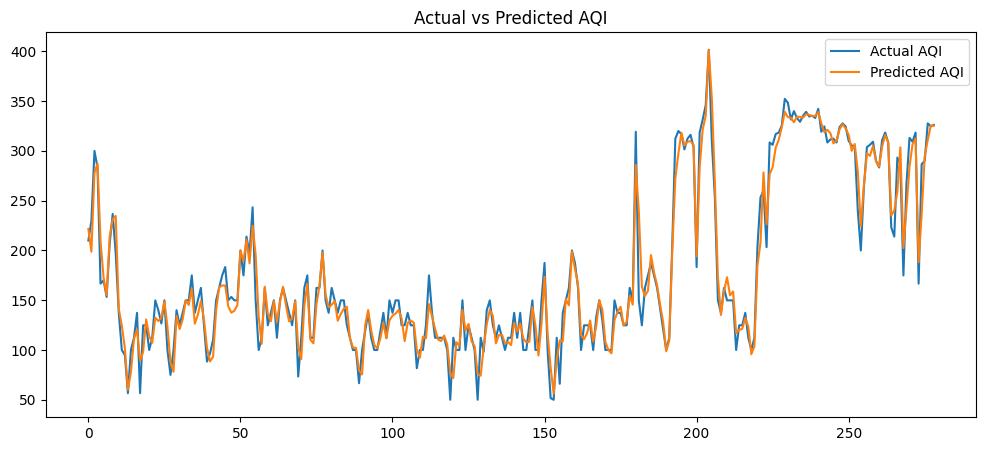

In [ ]:
#plotting actual vs predicted values.
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual AQI")
plt.plot(preds, label="Predicted AQI")
plt.legend()
plt.title("Actual vs Predicted AQI")
plt.show()

In [50]:
tomorrow = x.iloc[-1:]
tomorrow_aqi = model.predict(tomorrow)[0]

print("Tomorrow AQI:", round(tomorrow_aqi, 2))

Tomorrow AQI: 325.28


In [ ]:
# this predicted data is off by atleast 50 AQI points. Next step to increase accuracy => add wind, weather data. right now ONLY POLLUTION data is there